In [63]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 500
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import FancyArrowPatch
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [64]:
# FITS File 
image = 'Test/SIE/SIE_POS_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie = hdu_list[0].data[4]
gamma1_sie = np.array(gamma1_sie)

gamma2_sie = hdu_list[0].data[5]
gamma2_sie = np.array(gamma2_sie)

sie_pix = hdu_list[0].header['CDELT1']

Filename: Test/SIE/SIE_POS_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [65]:
# FITS File 
image = 'Test/SIE+SHEAR/SIE_POS_SHEAR_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie_shear = hdu_list[0].data[4]
gamma1_sie_shear = np.array(gamma1_sie_shear)

gamma2_sie_shear = hdu_list[0].data[5]
gamma2_sie_shear = np.array(gamma2_sie_shear)

sie_pix_shear = hdu_list[0].header['CDELT1']

Filename: Test/SIE+SHEAR/SIE_POS_SHEAR_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [66]:
# FITS File 
image = 'Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie_fix = hdu_list[0].data[4]
gamma1_sie_fix = np.array(gamma1_sie_fix)

gamma2_sie_fix = hdu_list[0].data[5]
gamma2_sie_fix = np.array(gamma2_sie_fix)

sie_pix_fix = hdu_list[0].header['CDELT1']

Filename: Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [67]:
gamma_sie = np.sqrt(gamma1_sie**2 + gamma2_sie**2)
gamma_sie_shear = np.sqrt(gamma1_sie_shear**2 + gamma2_sie_shear**2)
gamma_sie_fix = np.sqrt(gamma1_sie_fix**2 + gamma2_sie_fix**2)

In [68]:
obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1)
obs_point[0] = (obs_point[0] - 20)
obs_point[1] = (obs_point[1] - 20)
obs_point = obs_point[[0, 1]]
obs_point

,0,1
0,0.77773,0.30254
1,1.27308,0.95612
2,0.39091,1.05057
3,0.81981,1.25931


In [69]:
file_crit = 'Test/SIE/SIE_POS_crit.dat'
print(file_crit)
crit_curve_sie = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve_sie = (crit_curve_sie - 20) / sie_pix
crit_curve_sie

Test/SIE/SIE_POS_crit.dat


,0,1,2,3,4,5,6,7
0,825.50,312.00,822.76,716.27,825.00,312.50,822.74,716.78
1,825.50,312.00,822.76,716.27,826.50,312.00,822.76,716.24
2,826.50,312.00,822.76,716.24,827.50,312.00,822.76,716.21
3,827.50,312.00,822.76,716.21,828.50,312.00,822.76,716.17
4,828.50,312.00,822.76,716.17,829.50,312.00,822.76,716.14
...,...,...,...,...,...,...,...,...
3417,812.51,758.63,412.50,883.13,812.51,758.63,403.93,856.74
3418,812.51,758.63,403.93,856.74,812.51,758.63,397.27,830.05
3419,812.51,758.63,397.27,830.05,812.51,758.63,392.53,803.17
3420,812.51,758.63,392.53,803.17,812.51,758.63,389.70,776.20


In [70]:
file_crit = 'Test/SIE+SHEAR/SIE_POS_SHEAR_crit.dat'
print(file_crit)
crit_curve_sie_shear = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve_sie_shear = (crit_curve_sie_shear - 20) / sie_pix_shear
crit_curve_sie_shear

Test/SIE+SHEAR/SIE_POS_SHEAR_crit.dat


,0,1,2,3,4,5,6,7
0,799.50,233.00,803.48,723.75,799.00,233.50,803.50,724.15
1,799.50,233.00,803.48,723.75,800.50,233.00,803.48,723.80
2,800.50,233.00,803.48,723.80,801.50,233.00,803.49,723.84
3,801.50,233.00,803.49,723.84,802.50,233.00,803.49,723.88
4,802.50,233.00,803.49,723.88,803.50,233.00,803.49,723.93
...,...,...,...,...,...,...,...,...
4021,812.51,758.63,406.93,887.38,812.51,758.63,398.35,860.98
4022,812.51,758.63,398.35,860.98,812.51,758.63,391.70,834.29
4023,812.51,758.63,391.70,834.29,812.51,758.63,386.96,807.40
4024,812.51,758.63,386.96,807.40,812.51,758.63,384.12,780.43


In [71]:
file_crit = 'Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_crit.dat'
print(file_crit)
crit_curve_sie_fix = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve_sie_fix = (crit_curve_sie_fix - 20) / sie_pix_fix
crit_curve_sie_fix

Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_crit.dat


,0,1,2,3,4,5,6,7
0,799.50,311.00,812.74,791.68,799.00,311.50,812.77,792.17
1,799.50,311.00,812.74,791.68,800.50,311.00,812.74,791.74
2,800.50,311.00,812.74,791.74,801.50,311.00,812.74,791.80
3,801.50,311.00,812.74,791.80,802.50,311.00,812.75,791.86
4,802.50,311.00,812.75,791.86,803.50,311.00,812.75,791.92
...,...,...,...,...,...,...,...,...
4017,813.71,783.84,370.05,951.57,813.71,783.84,358.33,915.49
4018,813.71,783.84,358.33,915.49,813.71,783.84,349.15,878.68
4019,813.71,783.84,349.15,878.68,813.71,783.84,342.58,841.41
4020,813.71,783.84,342.58,841.41,813.71,783.84,338.64,803.95


In [72]:
pred_point = pd.read_csv('Test/SIE/SIE_POS_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / sie_pix
pred_point[1] = (pred_point[1] - 20) / sie_pix
pred_point_sie = pred_point[[0, 1]]
pred_point_sie

,0,1
0,887.5,385.0
1,408.5,903.7
2,1133.1,1049.5
3,679.5,1162.6


In [73]:
pred_point = pd.read_csv('Test/SIE+SHEAR/SIE_POS_SHEAR_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / sie_pix_shear
pred_point[1] = (pred_point[1] - 20) / sie_pix_shear
pred_point_shear = pred_point[[0, 1]]
pred_point_shear

,0,1
0,777.7,302.5
1,1273.1,956.1
2,390.9,1050.6
3,819.8,1259.3


In [74]:
pred_point = pd.read_csv('Test/SIE+SHEAR+FIXED/SIE_POS_SHEAR_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / sie_pix_fix
pred_point[1] = (pred_point[1] - 20) / sie_pix_fix
pred_point_fix = pred_point[[0, 1]]
pred_point_fix

,0,1
0,777.7,302.5
1,1273.1,956.1
2,390.9,1050.6
3,819.8,1259.3


In [75]:
# Row Switching

dist_matrix = cdist(obs_point.to_numpy(), pred_point_sie.to_numpy(), 'euclidean')
obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)
pred_point_sie_sort = pred_point_sie.iloc[pred_indices_optimal].reset_index(drop=True)
print(pred_point_sie_sort)

dist_matrix = cdist(obs_point.to_numpy(), pred_point_shear.to_numpy(), 'euclidean')
obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)
pred_point_shear_sort = pred_point_shear.iloc[pred_indices_optimal].reset_index(drop=True)
print(pred_point_shear_sort)

dist_matrix = cdist(obs_point.to_numpy(), pred_point_fix.to_numpy(), 'euclidean')
obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)
pred_point_fix_sort = pred_point_fix.iloc[pred_indices_optimal].reset_index(drop=True)
print(pred_point_fix_sort)

        0       1
0   887.5   385.0
1  1133.1  1049.5
2   408.5   903.7
3   679.5  1162.6
        0       1
0   777.7   302.5
1  1273.1   956.1
2   390.9  1050.6
3   819.8  1259.3
        0       1
0   777.7   302.5
1  1273.1   956.1
2   390.9  1050.6
3   819.8  1259.3


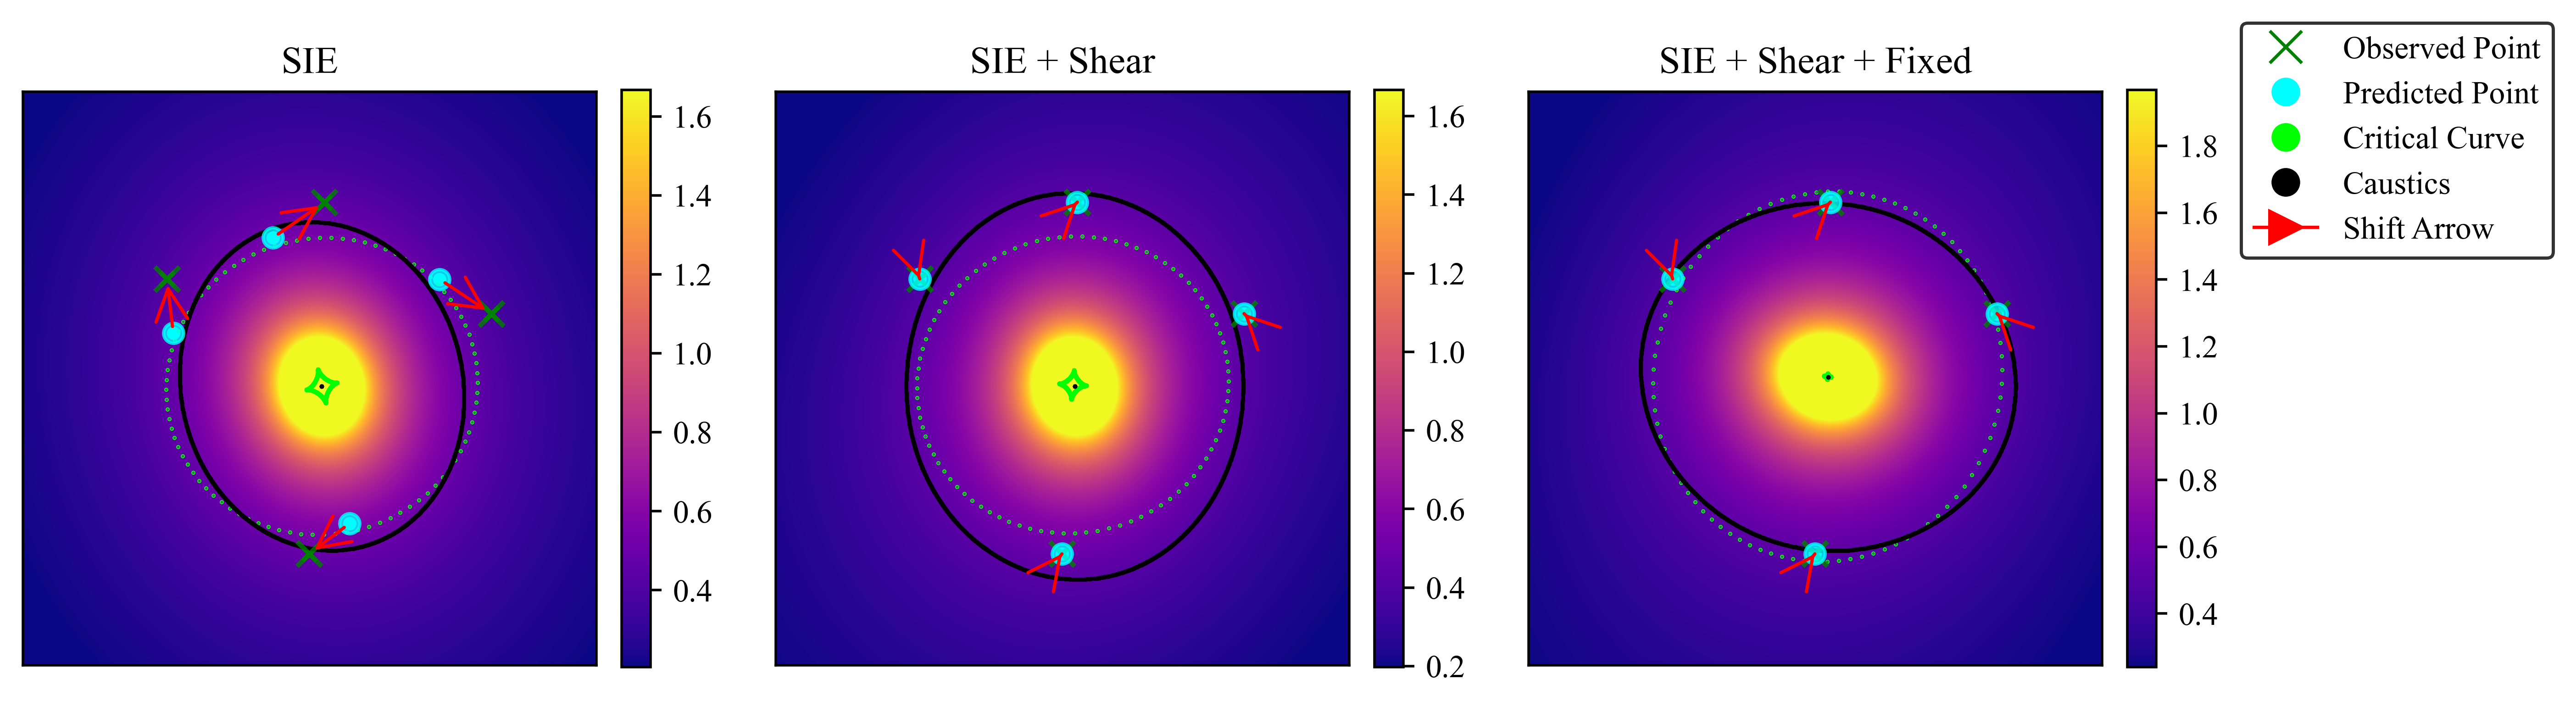

In [76]:
# Plot all 3 figures
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# SIE
vmax, vmin = np.percentile(gamma_sie, [98, 2])

ax = axs[0]
ax.imshow(gamma_sie, origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
ax.scatter(obs_point[0]/sie_pix, obs_point[1]/sie_pix, color='green', s=20, label='Observed Point', marker='x')
ax.scatter(pred_point_sie_sort[0], pred_point_sie_sort[1], color='cyan', s=10, label='Predicted Point')
ax.scatter(crit_curve_sie[2], crit_curve_sie[3], color='lime', label='Critical Curve', s=0.1)
ax.scatter(crit_curve_sie[4], crit_curve_sie[5], color='k', label='Caustics', s=0.1)
ax.set_title('SIE')
ax.set_xticks([])
ax.set_yticks([])
ax.colourbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

for j in range(len(pred_point)):  # len = 4 assumed
        x_obs, y_obs = obs_point.iloc[j, 0]/sie_pix, obs_point.iloc[j, 1]/sie_pix
        x_pred, y_pred = pred_point_sie_sort.iloc[j, 0], pred_point_sie_sort.iloc[j, 1]

        # Plot each point
        ax.scatter(x_obs, y_obs, color='green', s=60, alpha=0.8, marker='x')
        ax.scatter(x_pred, y_pred, color='cyan', s=40, alpha=0.8, marker='o')

        # Draw arrow
        arrow = FancyArrowPatch(
            posA=(x_pred, y_pred),
            posB=(x_obs, y_obs),
            arrowstyle='->',
            color='red',
            linewidth=1,
            mutation_scale=25,
            alpha=1
        )
        ax.add_patch(arrow)


# SIE + Shear
vmax, vmin = np.percentile(gamma_sie_shear, [98, 2])

ax = axs[1]
ax.imshow(gamma_sie_shear, origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
ax.scatter(obs_point[0]/sie_pix_shear, obs_point[1]/sie_pix_shear, color='green', s=20, label='Observed Point', marker='x')
ax.scatter(pred_point_shear_sort[0], pred_point_shear_sort[1], color='cyan', s=10, label='Predicted Point')
ax.scatter(crit_curve_sie_shear[2], crit_curve_sie_shear[3], color='lime', label='Critical Curve', s=0.1)
ax.scatter(crit_curve_sie_shear[4], crit_curve_sie_shear[5], color='k', label='Caustics', s=0.1)
ax.set_title('SIE + Shear')
ax.set_xticks([])
ax.set_yticks([])
ax.colourbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

for j in range(len(pred_point)):  # len = 4 assumed
        x_obs, y_obs = obs_point.iloc[j, 0]/sie_pix_shear, obs_point.iloc[j, 1]/sie_pix_shear
        x_pred, y_pred = pred_point_shear_sort.iloc[j, 0], pred_point_shear_sort.iloc[j, 1]

        # Plot each point
        ax.scatter(x_obs, y_obs, color='green', s=60, alpha=0.8, marker='x')
        ax.scatter(x_pred, y_pred, color='cyan', s=40, alpha=0.8, marker='o')

        # Draw arrow
        arrow = FancyArrowPatch(
            posA=(x_pred, y_pred),
            posB=(x_obs, y_obs),
            arrowstyle='->',
            color='red',
            linewidth=1,
            mutation_scale=25,
            alpha=1
        )
        ax.add_patch(arrow)

# SIE + Shear + Fixed
vmax, vmin = np.percentile(gamma_sie_fix, [98, 2])

ax = axs[2]
ax.imshow(gamma_sie_fix, origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
ax.scatter(obs_point[0]/sie_pix_fix, obs_point[1]/sie_pix_fix, color='green', s=20, label='Observed Point', marker='x')
ax.scatter(pred_point_fix_sort[0], pred_point_fix_sort[1], color='cyan', s=10, label='Predicted Point')
ax.scatter(crit_curve_sie_fix[2], crit_curve_sie_fix[3], color='lime', label='Critical Curve', s=0.1)
ax.scatter(crit_curve_sie_fix[4], crit_curve_sie_fix[5], color='k', label='Caustics', s=0.1)
ax.set_title('SIE + Shear + Fixed')
ax.set_xticks([])
ax.set_yticks([])
ax.colourbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

for j in range(len(pred_point)):  # len = 4 assumed
        x_obs, y_obs = obs_point.iloc[j, 0]/sie_pix_fix, obs_point.iloc[j, 1]/sie_pix_fix
        x_pred, y_pred = pred_point_fix_sort.iloc[j, 0], pred_point_fix_sort.iloc[j, 1]

        # Plot each point
        ax.scatter(x_obs, y_obs, color='green', s=60, alpha=0.8, marker='x')
        ax.scatter(x_pred, y_pred, color='cyan', s=40, alpha=0.8, marker='o')

        # Draw arrow
        arrow = FancyArrowPatch(
            posA=(x_pred, y_pred),
            posB=(x_obs, y_obs),
            arrowstyle='->',
            color='red',
            linewidth=1,
            mutation_scale=25,
            alpha=1
        )
        ax.add_patch(arrow)

legend_elements = [
    Line2D([0], [0], marker='x', color='w', markerfacecolor='green', markeredgecolor='green', markersize=5, label='Observed Point'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=5, label='Predicted Point'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=5, label='Critical Curve'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5, label='Caustics'),
    Line2D([0], [0], color='red', lw=1, label='Shift Arrow', marker='>', markersize=5, linestyle='-')
]

fig.legend(handles=legend_elements, loc='upper right', fontsize = 'medium', bbox_to_anchor=(1.05, 0.9), markerscale=2, frameon=True, facecolor='white', framealpha=0.8, edgecolor='black')
plt.show()